In [31]:
#rana.banik@vanderbilt.edu#
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%D")
print("Current Time =", current_time)
import numpy as np
import os
from glob import glob
import nibabel as nib
import matplotlib.pyplot as plt
import torch

Current Time = 06/07/21


In [8]:
def get_sub_list(train_img_dir):
    """
    :param train_img_dir: t1 MR folder
    :return: list of img names and list of images whole paths
    """
    image_list = []
    image_files = glob(os.path.join(train_img_dir, "*.nii.gz"))
    image_files.sort()
    for name in image_files:
        image_list.append(os.path.basename(name)[:-14])
    return image_list, image_files

In [4]:
def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    if input.dim() == 5:
        return input
    assert input.dim() == 4
    # expand the input tensor to Nx1xDxHxW before scattering
    input = input.unsqueeze(1)
    # create result tensor shape (NxCxDxHxW)
    shape = list(input.size())
    shape[1] = C

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the lib tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        tz = torch.zeros(shape).to(input.device)
        return tz.scatter_(1, input, 1)

for one-hot encoding from torch, the segmentation mask values have to be $0$ to $C-1$ <br> The values datatype must be `torch.int64`

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
project_dir = r'/media/banikr2/DATA/emModels/CT-MR_batch2/TrialMove/patchdir/LowResHeadSegTrial'
imgDir = os.path.join(project_dir, 'img')
# imgFiles = glob(os.path.join(imgDir, '*.gz'))
segDir = os.path.join(project_dir, 'seg')
train_img_subs, train_img_files = get_sub_list(imgDir)
# print(train_img_files)
train_seg_subs, train_seg_files = get_sub_list(segDir)
# print(train_seg_files)

train_dict = {}
train_dict['img_subs'] = train_img_subs
train_dict['img_files'] = train_img_files
train_dict['seg_subs'] = train_seg_subs
train_dict['seg_files'] = train_seg_files
segnb = nib.load(train_dict['seg_files'][0])

# +------------------------------------+
# | implementation of one-hot encoding
# +------------------------------------+
segnp = segnb.get_fdata() #.astype('float32')
labels = [0, 1, 2, 3, 4, 8, 10, 11, 56]
Ltmp = np.copy(segnp)
for use_idx, use_label in enumerate(labels):
    # print('USE_LABEL: map {} to {}'.format(use_label, use_idx))
    segnp[Ltmp == use_label] = use_idx

print(segnp.shape)
segt = segnp[None, ...]
# segt = torch.tensor(segt)
segt = torch.tensor(segt, dtype=torch.int64)
print(segt.shape)   # torch.Size([1, 48, 64, 64])
# segtt = segt.scatter(1, 1, segt)
# print(segtt.shape)
seg1h = expand_as_one_hot(segt, 9)
print(seg1h.shape, seg1h.unique())

seg1hnp = seg1h.numpy()
seg1hnp = np.squeeze(seg1hnp)
print(seg1hnp.shape)

(48, 64, 64)
torch.Size([1, 48, 64, 64])
torch.Size([1, 9, 48, 64, 64]) tensor([0., 1.])
(9, 48, 64, 64)


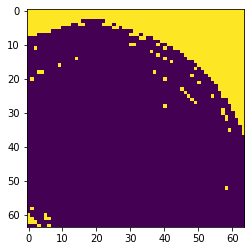

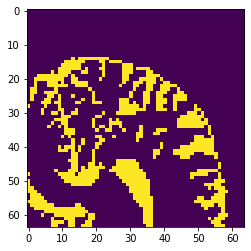

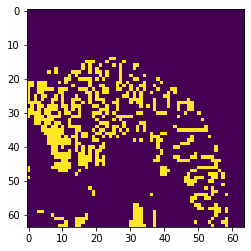

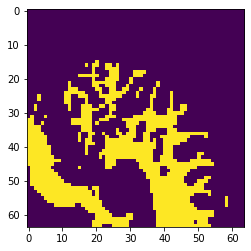

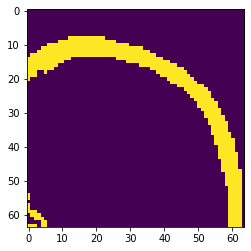

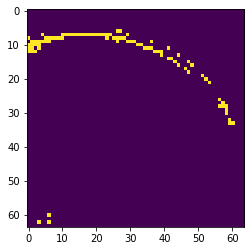

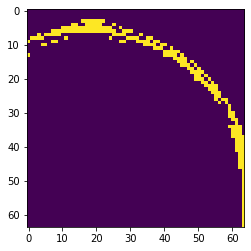

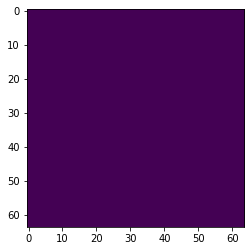

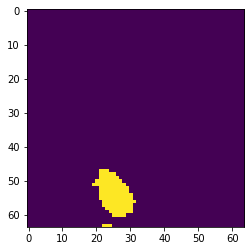

In [22]:
for i in range(len(labels)):
    plt.imshow(seg1hnp[i, 24, ...])
    plt.show()

The segmentation mask didn't have any eyeball(label=11) in it. So the channel is blank. 